In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
portfolio_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.YFData.download('BTC-USD').get('Close')

In [4]:
print(price)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2021-05-30 00:00:00+00:00    35678.128906
2021-05-31 00:00:00+00:00    37332.855469
2021-06-01 00:00:00+00:00    36684.925781
2021-06-02 00:00:00+00:00    37575.179688
2021-06-03 00:00:00+00:00    38940.500000
Name: Close, Length: 2448, dtype: float64


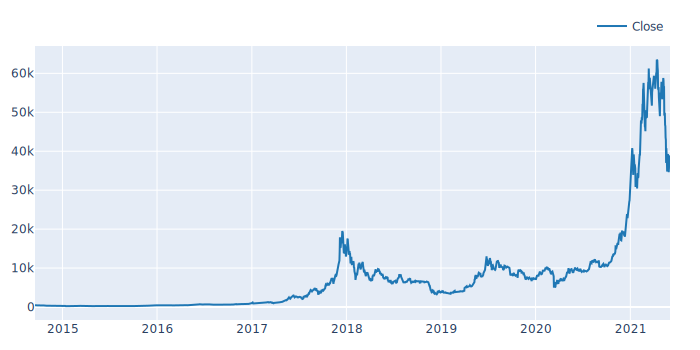

In [5]:
price.vbt.plot().show_svg()

In [6]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

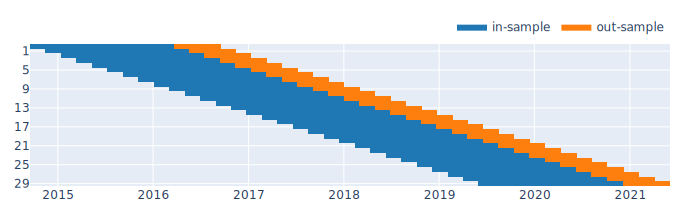

In [7]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_svg()

In [8]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [9]:
def simulate_holding(price, **kwargs):
    portfolio = vbt.Portfolio.from_holding(price, **kwargs)
    return portfolio.sharpe_ratio()

In [10]:
in_hold_sharpe = simulate_holding(in_price, **portfolio_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.517865
2     1.454923
3     1.209162
4     1.628978
5     1.659286
6     2.218942
7     2.074573
8     2.343282
9     2.787775
10    2.868753
11    2.908361
12    2.594558
13    2.323164
14    1.807816
15    1.735653
16    1.650763
17    0.715129
18    0.392459
19    0.372582
20   -0.147073
21    0.494075
22    0.390359
23    0.382138
24    0.761988
25    0.492051
26    1.227240
27    1.478171
28    1.074659
29    1.117898
Name: sharpe_ratio, dtype: float64


In [11]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [12]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **portfolio_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.093530
                          2            0.408405
                          3            0.346388
                          4            0.654299
                                         ...   
48           49           25           0.394994
                          26          -0.062408
                          27          -0.183125
                          28          -0.874102
                          29          -1.103122
Name: sharpe_ratio, Length: 23400, dtype: float64


In [13]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [14]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (20, 41,  4),
            (23, 25,  5),
            (37, 43,  6),
            (37, 43,  7),
            (31, 49,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 22, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (10, 22, 18),
            (17, 22, 19),
            (17, 23, 20),
            (13, 21, 21),
            (45, 49, 22),
            (45, 49, 23),
            (18, 21, 24),
            (13, 21, 25),
            (13, 21, 26),
            (13, 20, 27),
            (13, 20, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [15]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [16]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [20 41]
 [23 25]
 [37 43]
 [37 43]
 [31 49]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 22]
 [17 22]
 [17 23]
 [13 21]
 [45 49]
 [45 49]
 [18 21]
 [13 21]
 [13 21]
 [13 20]
 [13 20]
 [13 20]]


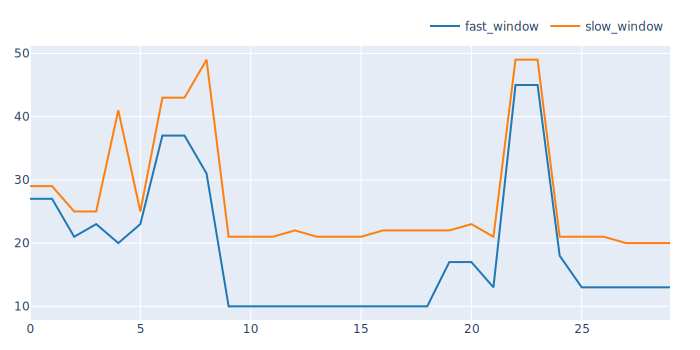

In [17]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_svg()

In [18]:
out_hold_sharpe = simulate_holding(out_price, **portfolio_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     1.934571
2     0.932176
3     2.935277
4     3.321579
5     3.387580
6     3.667760
7     3.557163
8     3.744816
9     2.216762
10    1.039014
11   -1.195431
12   -1.000219
13   -1.165398
14   -1.043329
15   -1.420631
16   -0.285439
17    3.041654
18    2.830007
19    1.448369
20   -0.292846
21    0.209520
22    0.015216
23    1.189794
24    0.892042
25    1.689844
26    3.007289
27    3.962586
28    4.860232
29    2.034696
Name: sharpe_ratio, dtype: float64


In [19]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **portfolio_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -0.517213
                          2            0.954205
                          3            0.257959
                          4            2.250128
                                         ...   
48           49           25          -1.692895
                          26          -0.344707
                          27           2.949950
                          28           3.647327
                          29           1.027001
Name: sharpe_ratio, Length: 23400, dtype: float64


In [20]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [21]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **portfolio_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
                      1            0.210568
21         25         2            0.921108
23         25         3            1.797342
20         41         4            0.228998
23         25         5            2.214971
37         43         6            0.968100
                      7           -1.153715
31         49         8            1.455443
10         21         9            3.231750
                      10           2.306887
                      11           1.297693
           22         12           1.858851
           21         13           0.653616
                      14           0.322501
                      15           0.573580
           22         16           2.344098
                      17           1.998689
                      18           0.452671
17         22         19          -0.084206
           23         20          -0.606754
13         21         21           1.772108


In [22]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

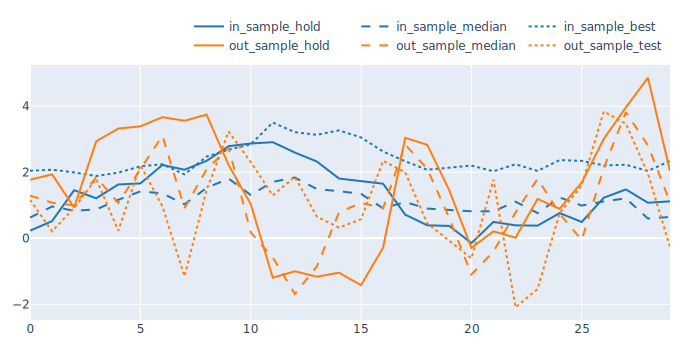

In [23]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()